<h1>A SymPy tutorial</h1>

<p>This tutorial provides an introduction to using <code>SymPy</code> within <code>Julia</code>. It owes an enormous debt to the tutorial for using SymPy within Python which may be found <a href="http://docs.sympy.org/dev/tutorial/index.html">here</a>. The overall structure and many examples are taken from that work, with adjustments and additions to illustrate the differences due to using <code>SymPy</code> within <code>Julia</code>.</p>

<p>This tutorial can be read as an <code>IJulia</code> notebook <a href="http://nbviewer.ipython.org/github/jverzani/SymPy.jl/blob/master/examples/tutorial.ipynb">here</a>.</p>

<p>After installing <code>SymPy</code>, which is discussed in the package's <code>README</code> file, we must first load it into <code>Julia</code> with the standard command <code>using</code>:</p>

In [1]:
using SymPy

<p>The start up time is a bit lengthy.</p>

<h2>Symbols</h2>

<p>At the core of <code>SymPy</code> is the introduction of symbolic variables that differ quite a bit from <code>Julia</code>'s variables. Symbolic variables do not immediately evaluate to a value, rather the "symbolicness" propagates when interacted with. To keep things manageable, SymPy does some simplifications along the way.</p>

<p>Symbolic expressions are primarily of the <code>Sym</code> type and can be constructed in the standard way:</p>

In [1]:
x = Sym("x")

<p>This creates a symbolic object <code>x</code>, which can be manipulated through further function calls.</p>

<p>There is the <code>@vars</code> macro that makes creating multiple variables a bit less typing, as it creates variables in the local scope – no assignment is necessary. Compare these similar ways to create symbolic variables:</p>

In [1]:
@vars a b c
a,b,c = Sym("a,b,c")

(a, b, c)

<p>(There is the identical <code>@syms</code> for MATLAB users.)</p>

<h3>Assumptions</h3>

<p>Finally, there is the <code>symbols</code> constructor for producing symbolic objects. With <code>symbols</code> it is possible to pass assumptions onto the variables. A list of possible assumptions is <a href="http://docs.sympy.org/dev/modules/core.html#module-sympy.core.assumptions">here</a>. Some examples are:</p>

In [1]:
u = symbols("u")
x = symbols("x", real=true)
y1, y2 = symbols("y1, y2", positive=true)
alpha = symbols("alpha", integer=true, positive=true)

<p>As seen, the <code>symbols</code> function can be used to make one or more variables with zero, one or more assumptions.</p>

<p>We jump ahead for a second to illustrate, but here we see that <code>solve</code> will respect these assumptions, by failing to find solutions to these equations:</p>

In [1]:
solve(x^2 + 1)   # ±i are not real

0-element Array{Any,1}

In [1]:
solve(y1 + 1)    # -1 is not positive

0-element Array{Any,1}

<p>The <code>@vars</code> macro can also have assumptions passed in as follows:</p>

In [1]:
@vars u1 u2 positive=true
solve(u1 + u2)  # empty, though solving u1 - u2 is not.

0-element Array{Any,1}

<p>As can be seen, there are several ways to create symbolic values. One caveat is that one can't use <code>Sym</code> to create a variable from a function name in Base.</p>

<h3>Special constants</h3>

<p><code>Julia</code> has its math constants, like <code>pi</code> and <code>e</code>, <code>SymPy</code> as well. A few of these have <code>Julia</code> counterparts provided by <code>SymPy</code>. For example, these two constants are defined (where <code>oo</code> is for infinity):</p>

In [1]:
PI,  oo

(pi, oo)

<p>(The pretty printing of SymPy objects does not work for tuples.)</p>

<p>Numeric values themselves can be symbolic. This example shows the difference. The first <code>asin</code> call dispatches to <code>Julia</code>'s <code>asin</code> function, the second to <code>SymPy</code>'s:</p>

In [1]:
[asin(1), asin(Sym(1))]

<h2>Substitution</h2>

<p>SymPy provides a means to substitute values in for the symbolic expressions. The specification requires an expression, a variable in the expression to substitute in for, and a new value. For example, this is one way to make a polynomial in a new variable:</p>

In [1]:
@vars x y
ex = x^2 + 2x + 1
ex.subs(x, y)

<p>Substitution can also be numeric:</p>

In [1]:
ex.subs(x, 0)

<p>The output has no free variables, but is still symbolic.</p>

<p>Expressions with more than one variable can have multiple substitutions, where each is expressed as a tuple:</p>

In [1]:
x,y,z = symbols("x,y,z")
ex = x + y + z
ex.subs((x,1), (y,pi))

In [1]:
note("""
The calling pattern for `subs` is different from a typical `Julia` function call. The `subs` call is `object.method(arguments)` whereas a more "`Julia`n" function call is `method(objects, other objects....)`, as `Julia` offers multiple dispatch of methods. `SymPy` uses the Python calling method, adding in `Julia`n style when appropriate for generic usage within `Julia`. In addition, `SymPy` imports all functions from the underlying `sympy` module and specializes them on a symbolic first argument.

For `subs`, the simple substitution `ex.object(x,a)` is similar to simple function evaluation, so `Julia`'s call notation will work. To specify the pairing off of `x` and `a`, the `=>`  pairs notation is used.
""")

<div class="alert alert-info" role="alert">

<div class="markdown"><p>The calling pattern for <code>subs</code> is different from a typical <code>Julia</code> function call. The <code>subs</code> call is <code>object.method&#40;arguments&#41;</code> whereas a more "<code>Julia</code>n" function call is <code>method&#40;objects, other objects....&#41;</code>, as <code>Julia</code> offers multiple dispatch of methods. <code>SymPy</code> uses the Python calling method, adding in <code>Julia</code>n style when appropriate for generic usage within <code>Julia</code>. In addition, <code>SymPy</code> imports all functions from the underlying <code>sympy</code> module and specializes them on a symbolic first argument.</p>
<p>For <code>subs</code>, the simple substitution <code>ex.object&#40;x,a&#41;</code> is similar to simple function evaluation, so <code>Julia</code>'s call notation will work. To specify the pairing off of <code>x</code> and <code>a</code>, the <code>&#61;&gt;</code>  pairs 

<p>This calling style will be equivalent to the last:</p>

In [1]:
ex(x=>1, y=>pi)

<p>A straight call is also possble, where the order of the variables is determined by <code>free_symbols</code>:</p>

In [1]:
ex(1, pi)

<p>This is useful for expressions of a single variable, but being more explicit through the use of paired values would be recommended.</p>

<h2>Conversion from symbolic to numeric</h2>

<p>SymPy provides two identical means to convert a symbolic math expression to a number. One is <code>evalf</code>, the other <code>N</code>. Within <code>Julia</code> we decouple this, using <code>N</code> to also convert to a <code>Julian</code> value and <code>evalf</code> to leave the conversion as a symbolic object.  The <code>N</code> function converts symbolic integers, rationals, irrationals, and complex values, while attempting to find an appropriate <code>Julia</code> type for the value.</p>

<p>To see the difference, we use both on <code>PI</code>:</p>

In [1]:
N(PI)  # converts to underlying pi irrational

π = 3.1415926535897...

<p>Whereas, <code>evalf</code> will produce a symbolic numeric value:</p>

In [1]:
(PI).evalf()

<p>The <code>evalf</code> call allows for a precision argument to be passed through the second argument. This is how 30 digits of $\pi$ can be extracted:</p>

In [1]:
PI.evalf(30)

<p>This is a SymPy, symbolic number, not a <code>Julia</code> object. Composing with <code>N</code></p>

In [1]:
N(PI.evalf(30))

3.141592653589793238462643383279999999999999999999999999999999999999999999999985

<p>will produce a <code>Julia</code> number,</p>

<p>Explicit conversion via <code>convert&#40;T, ex&#41;</code> can also be done, and is necessary at times if <code>N</code> does not give the desired type.</p>

<h2>Algebraic expressions</h2>

<p><code>SymPy</code> overloads many of <code>Julia</code>'s functions to work with symbolic objects, such as seen above with <code>asin</code>. The usual mathematical operations such as <code>&#43;</code>, <code>*</code>, <code>-</code>, <code>/</code> etc. work through <code>Julia</code>'s promotion mechanism, where numbers are promoted to symbolic objects, others dispatch internally to related <code>SymPy</code> functions.</p>

<p>In most all  cases, thinking about this distinction between numbers and symbolic numbers is unnecessary, as numeric values passed to <code>SymPy</code> functions are typically promoted to symbolic expressions. This conversion will take math constants to their corresponding <code>SymPy</code> counterpart, rational expressions to rational expressions, and floating point values to floating point values. However there are edge cases. An expression like <code>1//2 * pi * x</code> will differ from the seemingly identical  <code>1//2 * &#40;pi * x&#41;</code>. The former will produce a floating point value from <code>1//2 * pi</code> before being promoted to a symbolic instance. Using the symbolic value <code>PI</code> makes this expression work either way.</p>

<p>Most of <code>Julia</code>'s <a href="http://julia.readthedocs.org/en/latest/manual/mathematical-operations/#elementary-functions">mathematical</a> functions are overloaded to work with symbolic expressions. <code>Julia</code>'s generic definitions are used, as possible. This also introduces some edge cases. For example, <code>x^&#40;-2&#41;</code> will balk due to the negative, integer exponent, but either <code>x^&#40;-2//1&#41;</code> or <code>x^Sym&#40;-2&#41;</code> will work as expected, as the former call first dispatches to a generic defintion, but the latter two expressions do not.</p>

<p><code>SymPy</code> makes it very easy to work with polynomial and rational expressions. First we create some variables:</p>

In [1]:
@vars x y z

(x, y, z)

<h3>The expand, factor, collect, and simplify functions</h3>

<p>A typical polynomial expression in a single variable can be written in two common ways, expanded or factored form. Using <code>factor</code> and <code>expand</code> can move between the two.</p>

<p>For example,</p>

In [1]:
p = x^2 + 3x + 2
factor(p)

<p>Or</p>

In [1]:
expand(prod((x-i) for i in 1:5))

<p>The <code>factor</code> function factors over the rational numbers, so something like this with obvious factors is not finished:</p>

In [1]:
factor(x^2 - 2)

<p>When expressions involve one or more variables, it can be convenient to be able to manipulate them. For example, if we define <code>q</code> by:</p>

In [1]:
q = x*y + x*y^2 + x^2*y + x

<p>Then we can collect the terms by the variable <code>x</code>:</p>

In [1]:
collect(q, x)

<p>or the variable <code>y</code>:</p>

In [1]:
collect(q, y)

<p>These are identical expressions, though viewed differently.</p>

<p>A more broad-brush approach is to let <code>SymPy</code> simplify the values. In this case, the common value of <code>x</code> is factored out:</p>

In [1]:
simplify(q)

<p>The <code>simplify</code> function attempts to apply the dozens of functions related to simplification that are part of SymPy. It is also possible to apply these functions one at a time, for example <code>trigsimp</code> does trigonometric simplifications.</p>

<p>The SymPy tutorial illustrates that <code>expand</code> can also result in simplifications through this example:</p>

In [1]:
expand((x + 1)*(x - 2) - (x - 1)*x)

<p>These methods are not restricted to polynomial expressions and will work with other expressions. For example, <code>factor</code> identifies the following as a factorable object in terms of the variable <code>exp&#40;x&#41;</code>:</p>

In [1]:
factor(exp(2x) + 3exp(x) + 2)

<h2>Rational expressions: apart, together, cancel</h2>

<p>When working with rational expressions, SymPy does not do much simplification unless asked. For example this expression is not simplified:</p>

In [1]:
r = 1/x + 1/x^2

<p>To put the terms of <code>r</code> over a common denominator, the <code>together</code> function is available:</p>

In [1]:
together(r)

<p>The <code>apart</code> function does the reverse, creating a partial fraction decomposition from a ratio of polynomials:</p>

In [1]:
apart( (4x^3 + 21x^2 + 10x + 12) /  (x^4 + 5x^3 + 5x^2 + 4x))

<p>Some times SymPy will cancel factors, as here:</p>

In [1]:
top = (x-1)*(x-2)*(x-3)
bottom = (x-1)*(x-4)
top/bottom

<p>(This might make math faculty a bit upset, but it is in line with student thinking.)</p>

<p>However, with expanded terms, the common factor of <code>&#40;x-1&#41;</code> is not cancelled:</p>

In [1]:
r = expand(top) / expand(bottom)

<p>The <code>cancel</code> function instructs SymPy to perform cancellations. It takes rational functions and puts them in a canonical $p/q$ form with no common (rational) factors and leading terms which are integers:</p>

In [1]:
cancel(r)

<h2>Powers</h2>

<p>The SymPy <a href="http://docs.sympy.org/dev/tutorial/simplification.html#powers">tutorial</a> offers a thorough explanation on powers and which get simplified and under what conditions. Basically</p>

<ul>
<li>$x^a x^b = x^{a+b}$
<p>is always true. However</p>
</li>
<li>$x^a y^a=(xy)^a$
<p>is only true with assumptions, such as $x,y \geq 0$ and $a$ is real, but not in general. For example, $x=y=-1$ and $a=1/2$ has $x^a \cdot y^a = i \cdot i =  -1$, where as $(xy)^a = 1$.</p>
</li>
<li>$(x^a)^b = x^{ab}$
<p>is only true with assumptions. For example $x=-1, a=2$, and $b=1/2$ gives $(x^a)^b = 1^{1/2} = 1$, whereas $x^{ab} = -1^1 = -1$.</p>
</li>
</ul>

<p>We see that with assumptions, the following expression does simplify to $0$:</p>

In [1]:
@vars x y nonnegative=true a real=true
simplify(x^a * y^a - (x*y)^a)

<p>However, without assumptions this is not the case</p>

In [1]:
x,y,a = symbols("x,y,a")
simplify(x^a * y^a - (x*y)^a)

<p>The <code>simplify</code> function calls <code>powsimp</code> to simplify powers, as above. The <code>powsimp</code> function has the keyword argument <code>force&#61;true</code> to force simplification even if assumptions are not specified:</p>

In [1]:
powsimp(x^a * y^a - (x*y)^a, force=true)

<h2>Trigonometric simplification</h2>

<p>For trigonometric expressions, <code>simplify</code> will use <code>trigsimp</code> to simplify:</p>

In [1]:
theta = symbols("theta", real=true)
p = cos(theta)^2 + sin(theta)^2

<p>Calling either <code>simplify</code> or <code>trigsimp</code> will apply the Pythagorean identity:</p>

In [1]:
simplify(p)

<p>While often forgotten,  the <code>trigsimp</code> function is, of course,  aware of the double angle formulas:</p>

In [1]:
simplify(sin(2theta) - 2sin(theta)*cos(theta))

<p>The <code>expand_trig</code> function will expand such expressions:</p>

In [1]:
expand_trig(sin(2theta))

<h2>Coefficients</h2>

<p>Returning to polynomials, there are a few functions to find various pieces of the polynomials. First we make a general quadratic polynomial:</p>

In [1]:
a,b,c,x = symbols("a, b, c, x")
p = a*x^2 + b*x + c

<p>If given a polynomial, like <code>p</code>, there are different means to extract the coefficients:</p>

<ul>
<li><p>SymPy provides a <code>coeffs</code> method for <code>Poly</code> objects, but <code>p</code> must first be converted to one.</p>
</li>
<li><p>SymPy provides the <code>coeff</code> method for expressions, which allows extration of a coeffiecient for a given monomial</p>
</li>
</ul>

<p>The <code>ex.coeff&#40;monom&#41;</code> call will return the corresponding coefficient of the monomial:</p>

In [1]:
p.coeff(x^2) # a
p.coeff(x)   # b

<p>The constant can be found through substitution:</p>

In [1]:
p(x=>0)

<p>Though one could use some trick like this to find all the coefficients:</p>

In [1]:
Sym[[p.coeff(x^i) for i in N(degree(p,gen=x)):-1:1]; p(x=>0)]

<p>that is cumbersome, at best. SymPy has a function <code>coeffs</code>, but it is defined for polynomial types, so will fail on <code>p</code>:</p>

In [1]:
p.coeffs() # fails

KeyError("coeffs")


<p>Polynomials are a special class in SymPy and must be constructed. The <code>Poly</code> constructor can be used. As there is more than one free variable in <code>p</code>, we specify the variable <code>x</code> below:</p>

In [1]:
q = sympy.Poly(p, x)
q.coeffs()

In [1]:
note("""
The `Poly` constructor from SymPy is *not* a function, so is not exported when `SymPy` is loaded. To access it, the object must be qualified by its containing module, in this case `Poly`. Were it to be used frequently, an alias could be used, as in `const Poly=sympy.Poly` *or* the `import_from` function, as in `import_from(sympy, :Poly)`. The latter has some attempt to avoid naming collisions.
""")

<div class="alert alert-info" role="alert">

<div class="markdown"><p>The <code>Poly</code> constructor from SymPy is <em>not</em> a function, so is not exported when <code>SymPy</code> is loaded. To access it, the object must be qualified by its containing module, in this case <code>Poly</code>. Were it to be used frequently, an alias could be used, as in <code>const Poly&#61;sympy.Poly</code> <em>or</em> the <code>import_from</code> function, as in <code>import_from&#40;sympy, :Poly&#41;</code>. The latter has some attempt to avoid naming collisions.</p>
</div>

</div>


<h2>Polynomial roots: solve, real_roots, polyroots, nroots</h2>

<p>SymPy provides functions to find the roots of a polynomial. In general, a polynomial with real coefficients of degree $n$ will have $n$ roots when multiplicities and complex roots are accounted for. The number of real roots is consequently between $0$ and $n$.</p>

<p>For a <em>univariate</em> polynomial expression (a single variable), the real roots, when available, are returned by <code>roots</code>. For example,</p>

In [1]:
real_roots(x^2 - 2)

<p>Unlike <code>factor</code> – which only factors over rational factors – <code>real_roots</code> finds the two irrational roots here. It is well known (the <a href="http://en.wikipedia.org/wiki/Abel&#37;E2&#37;80&#37;93Ruffini_theorem">Abel-Ruffini theorem</a>) that for degree 5 polynomials, or higher, it is not always possible to express the roots in terms of radicals. However, when the roots are rational <code>SymPy</code> can have success:</p>

In [1]:
p = (x-3)^2*(x-2)*(x-1)*x*(x+1)*(x^2 + x + 1)
real_roots(p)

<p>In this example, the degree of <code>p</code> is 8, but only the 6 real roots returned, the double root of $3$ is accounted for. The two complex roots of <code>x^2 &#43; x&#43; 1</code> are not considered by this function. The complete set of distinct roots can be found with <code>solve</code>:</p>

In [1]:
solve(p)

<p>This finds the complex roots, but does not account for the double root. The <code>roots</code> function of SymPy does.</p>

<p>The output of calling <code>roots</code> will be a dictionary whose keys are the roots and values the multiplicity.</p>

In [1]:
roots(p)

Dict{Any,Any} with 7 entries:
  1 => 1
  -1/2 - sqrt(3)*I/2 => 1
  3 => 2
  0 => 1
  -1 => 1
  -1/2 + sqrt(3)*I/2 => 1
  2 => 1

<p>When exact answers are not provided, the <code>roots</code> call is contentless:</p>

In [1]:
p = x^5 - x + 1
roots(p)

Dict{Any,Any} with 0 entries

<p>Calling <code>solve</code> seems to produce very little as well:</p>

In [1]:
rts = solve(p)

<p>But in fact, <code>rts</code> contains lots of information. We can extract numeric values quite easily with <code>N</code>:</p>

In [1]:
N.(rts)

5-element Array{Number,1}:
                                                                                   -1.167303978261418684256045899854842180720560371525489039140082449275651903429536     
 -0.1812324444698754000000000000000000000000000000000000000000000000000000000000002 - 1.083954101317711000000000000000000000000000000000000000000000000000000000000005im 
 -0.1812324444698754000000000000000000000000000000000000000000000000000000000000002 + 1.083954101317711000000000000000000000000000000000000000000000000000000000000005im 
  0.7648844336005846999999999999999999999999999999999999999999999999999999999999979 - 0.3524715460317263000000000000000000000000000000000000000000000000000000000000007im
  0.7648844336005846999999999999999999999999999999999999999999999999999999999999979 + 0.3524715460317263000000000000000000000000000000000000000000000000000000000000007im

<p>These are numeric approximations to irrational values. For numeric approximations to polynomial roots, the <code>nroots</code> function is also provided, though with this call the answers are still symbolic:</p>

In [1]:
nroots(p)

<h2>The solve function</h2>

<p>The <code>solve</code> function is more general purpose than just finding roots of univariate polynomials. The function tries to solve for when an expression is 0, or a set of expressions are all 0.</p>

<p>For example, it can be used to solve when $\cos(x) = \sin(x)$:</p>

In [1]:
solve(cos(x) - sin(x))

<p>Though there are infinitely many correct solutions, these are within a certain range.</p>

<p>The <a href="http://docs.sympy.org/latest/modules/solvers/solveset.html">solveset</a> function appears in version 1.0 of SymPy and is an intended replacement for <code>solve</code>. Here we see it gives all solutions:</p>

In [1]:
u = solveset(cos(x) - sin(x))

<p>The output of <code>solveset</code> is a set, rather than a vector or dictionary. To get the values requires some work. For <em>finite sets</em> we collect the elements with <code>collect</code>, but first we must convert to a <code>Julia</code> <code>Set</code>:</p>

In [1]:
v = solveset(x^2 - 4)
collect(Set(v...))

2-element Array{Any,1}:
 -2
  2

<p>This composition is done in the <code>elements</code> function:</p>

In [1]:
elements(v)

<p>The <code>elements</code> function does not work for more complicated (non-finite) sets, such as <code>u</code>. For these, the <code>contains</code> method may be useful to query the underlying elements</p>

<p>Solving within Sympy has limits. For example, there is no symbolic solution here:</p>

In [1]:
solve(cos(x) - x)

PyError ($(Expr(:escape, :(ccall(#= /Users/verzani/.julia/packages/PyCall/RQjD7/src/pyfncall.jl:44 =# @pysym(:PyObject_Call), PyPtr, (PyPtr, PyPtr, PyPtr), o, pyargsptr, kw))))) <class 'NotImplementedError'>
NotImplementedError('multiple generators [x, cos(x)]\nNo algorithms are implemented to solve equation -x + cos(x)')
  File "/Users/verzani/.julia/conda/3/lib/python3.7/site-packages/sympy/solvers/solvers.py", line 1162, in solve
    solution = _solve(f[0], *symbols, **flags)
  File "/Users/verzani/.julia/conda/3/lib/python3.7/site-packages/sympy/solvers/solvers.py", line 1735, in _solve
    raise NotImplementedError('\n'.join([msg, not_impl_msg % f]))



<p>(And hence the error message generated.)</p>

<p>For such an equation, a numeric method would be needed, similar to the <code>Roots</code> package. For example:</p>

In [1]:
nsolve(cos(x) - x, 1)

<p>Though it can't solve everything, the <code>solve</code> function can also solve equations of a more general type. For example, here it is used to derive the quadratic equation:</p>

In [1]:
a,b,c  = symbols("a,b,c", real=true)
p = a*x^2 + b*x + c
solve(p, x)

<p>The extra argument <code>x</code> is passed to <code>solve</code> so that <code>solve</code> knows which variable to solve for.</p>

<p>The <code>solveset</code> function is similar:</p>

In [1]:
solveset(p, x)

<p>If the <code>x</code> value is not given, <code>solveset</code> will complain and  <code>solve</code> tries to find a solution with all the free variables:</p>

In [1]:
solve(p)

1-element Array{Dict{Any,Any},1}:
 Dict(a=>-(b*x + c)/x^2)

<p>Systems of equations can be solved as well. We specify them within a vector of expressions, <code>&#91;ex1, ex2, ..., exn&#93;</code> where a found solution is one where all the expressions are 0. For example, to solve this linear system: $2x + 3y = 6, 3x - 4y=12$, we have:</p>

In [1]:
x, y = symbols("x,y", real=true)
exs = [2x+3y-6, 3x-4y-12]
d = solve(exs)

Dict{Any,Any} with 2 entries:
  x => 60/17
  y => -6/17

<p>We can "check our work" by plugging into each equation. We take advantage of how the <code>subs</code> function allows us to pass in a dictionary:</p>

In [1]:
map(ex -> ex.subs(d), exs)

<p>In the previous example, the system had two equations and two unknowns. When that is not the case, one can specify the variables to solve for as a vector. In this example, we find a quadratic polynomial that approximates $\cos(x)$ near $0$:</p>

In [1]:
a,b,c,h = symbols("a,b,c,h", real=true)
p = a*x^2 + b*x + c
fn = cos
exs = [fn(0*h)-p(x=>0), fn(h)-p(x => h), fn(2h)-p(x => 2h)]
d = solve(exs, [a,b,c])

Dict{Any,Any} with 3 entries:
  c => 1
  b => (4*cos(h) - cos(2*h) - 3)/(2*h)
  a => (-2*cos(h) + cos(2*h) + 1)/(2*h^2)

<p>Again, a dictionary is returned. The polynomial itself can be found by substituting back in for <code>a</code>, <code>b</code>, and <code>c</code>:</p>

In [1]:
quad_approx = p.subs(d)

<p>(Taking the limit as $h$ goes to 0 produces the answer $1 - x^2/2$.)</p>

<p>Finally for <code>solve</code>, we show one way to re-express the polynomial $a_2x^2 + a_1x + a_0$ as $b_2(x-c)^2 + b_1(x-c) + b_0$ using <code>solve</code> (and not, say, an expansion theorem.)</p>

In [1]:
n = 3
x, c = symbols("x,c")
as = Sym["a$i" for i in 0:(n-1)]
bs = Sym["b$i" for i in 0:(n-1)]
p = sum([as[i+1]*x^i for i in 0:(n-1)])
q = sum([bs[i+1]*(x-c)^i for i in 0:(n-1)])
solve(p-q, bs)

Dict{Any,Any} with 3 entries:
  b0 => a0 + a1*c + a2*c^2
  b1 => a1 + 2*a2*c
  b2 => a2

<h3>Solving using logical operators</h3>

<p>The <code>solve</code> function does not need to just solve <code>ex &#61; 0</code>. There are other means to specify an equation. Ideally, it would be nice to say <code>ex1 &#61;&#61; ex2</code>, but the interpretation of <code>&#61;&#61;</code> is not for this. Rather, <code>SymPy</code> introduces <code>Eq</code> for equality. So this expression</p>

In [1]:
solve(Eq(x, 1))

<p>gives 1, as expected from solving <code>x &#61;&#61; 1</code>.</p>

<p>In addition to <code>Eq</code>, there are <code>Lt</code>, <code>Le</code>, <code>Ge</code>, <code>Gt</code>. The Unicode operators are not aliased to these, but there are alternatives <code>\ll&#91;tab&#93;</code>, <code>\leqq&#91;tab&#93;</code>, <code>\Equal&#91;tab&#93;</code>, <code>\geqq&#91;tab&#93;</code>, <code>\gg&#91;tab&#93;</code> and <code>\neg&#91;tab&#93;</code> to negate.</p>

<p>So, the above could have been written with the following nearly identical expression, though it is entered with <code>\Equal&#91;tab&#93;</code>.</p>

In [1]:
solve(x ⩵ 1)

<p>Here is an alternative way of asking a previous question on a pair of linear equations:</p>

In [1]:
x, y = symbols("x,y", real=true)
exs = [2x+3y ⩵ 6, 3x-4y ⩵ 12]    ## Using \Equal[tab]
d = solve(exs)

Dict{Any,Any} with 2 entries:
  x => 60/17
  y => -6/17

<h2>Plotting</h2>

<p>The <code>Plots</code> package allows many 2-dimensional plots of <code>SymPy</code> objects to be agnostic as to a backend plotting package.  <code>SymPy</code> provides recipes that allow symbolic expressions to be used where functions are part of the <code>Plots</code> interface. [See the help page for <code>sympy_plotting</code>.]</p>

<p>In particular, the following methods of <code>plot</code> are defined:</p>

<ul>
<li><p><code>plot&#40;ex::Sym, a, b&#41;</code> will plot the expression of single variable over the interval <code>&#91;a,b&#93;</code></p>
</li>
<li><p><code>plot&#33;&#40;ex::Sym, a, b&#41;</code> will add to the current plot a plot of  the expression of single variable over the interval <code>&#91;a,b&#93;</code></p>
</li>
<li><p><code>plot&#40;exs::Vector&#123;Sym&#125;, a, b&#41;</code> will plot each expression over <code>&#91;a,b&#93;</code></p>
</li>
<li><p><code>plot&#40;ex1, ex2, a, b&#41;</code> will plot a parametric plot of the two expressions over the interval <code>&#91;a,b&#93;</code>.</p>
</li>
<li><p><code>contour&#40;xs, ys, ex::Sym&#41;</code> will make a contour plot of the expression of two variables over the grid specifed by the <code>xs</code> and <code>ys</code>.</p>
</li>
<li><p><code>surface&#40;xs, ys, ex::Sym&#41;</code> will make a surface plot of the expression of two variables over the grid specifed by the <code>xs</code> and <code>ys</code>.</p>
</li>
</ul>

<p>For example:</p>

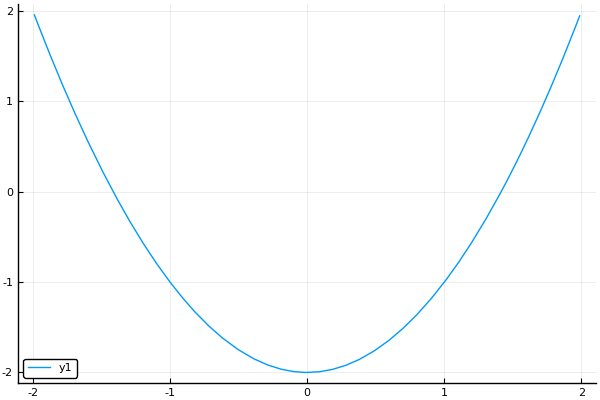

In [1]:
x = symbols("x")
using Plots
pyplot()
#
plot(x^2 - 2, -2,2)

<p>Or a parametric plot:</p>

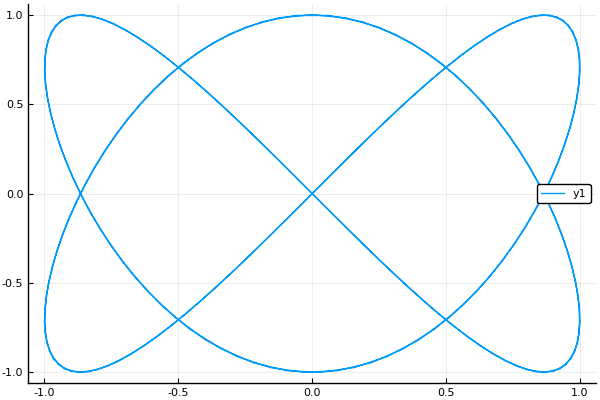

In [1]:
plot(sin(2x), cos(3x), 0, 4pi)

<p>For plotting with other plotting packages, it is generally faster to first call <code>lambdify</code> on the expression and then generate <code>y</code> values with the resulting <code>Julia</code> function.</p>

<hr />

<p>In addition, with <code>PyPlot</code> a few other plotting functions from <code>SymPy</code> are available from its interface to <code>MatplotLib</code>:</p>

<ul>
<li><p><code>plot3d_parametric_surface&#40;ex1::Sym, ex2::Sym, ex3::Sym&#41;, &#40;uvar, a0, b0&#41;, &#40;vvar, a1, b1&#41;&#41;</code> – make a surface plot of the expressions parameterized by the region <code>&#91;a0,b0&#93; x &#91;a1,b1&#93;</code>. The default region is <code>&#91;-5,5&#93;x&#91;-5,5&#93;</code> where the ordering of the variables is given by <code>free_symbols&#40;ex&#41;</code>.</p>
</li>
<li><p><code>plot_implicit&#40;predictate, &#40;xvar, a0, b0&#41;, &#40;yvar, a1, b1&#41;&#41;</code> – make</p>
</li>
</ul>

<p>an implicit equation plot of the expressions over the region <code>&#91;a0,b0&#93; x &#91;a1,b1&#93;</code>. The default region is <code>&#91;-5,5&#93;x&#91;-5,5&#93;</code> where the ordering of the variables is given by <code>free_symbols&#40;ex&#41;</code>.  To create predicates from the variable, the functions <code>Lt</code>, <code>Le</code>, <code>Eq</code>, <code>Ge</code>, and <code>Gt</code> can be used, as with <code>Lt&#40;x*y, 1&#41;</code>. For infix notation, unicode operators can be used: <code>\ll&lt;tab&gt;</code>, <code>\leqq&lt;tab&gt;</code>, <code>\Equal&lt;tab&gt;</code>, <code>\geqq&lt;tab&gt;</code>, and <code>\gg&lt;tab&gt;</code>. For example, <code>x*y ≪ 1</code>.  To combine terms, the unicode <code>\vee&lt;tab&gt;</code> (for "or"), <code>\wedge&lt;tab&gt;</code> (for "and") can be used.</p>

<h2>Calculus</h2>

<p><code>SymPy</code> has many of the basic operations of calculus provided through a relatively small handful of functions.</p>

<h3>Limits</h3>

<p>Limits are computed by the <code>limit</code> function which takes an expression, a variable and a value, and optionally a direction specified by either <code>dir&#61;&quot;&#43;&quot;</code> or <code>dir&#61;&quot;-&quot;</code>.</p>

<p>For example, this shows Gauss was right:</p>

In [1]:
limit(sin(x)/x, x, 0)

<p>Alternatively, the second and third arguments can be specified as a pair:</p>

In [1]:
limit(sin(x)/x, x=>0)

<p>Limits at infinity are done by using <code>oo</code> for $\infty$:</p>

In [1]:
limit((1+1/x)^x, x => oo)

<p>This example computes what L'Hopital reportedly paid a Bernoulli for</p>

In [1]:
a = symbols("a", positive=true)
ex = (sqrt(2a^3*x-x^4) - a*(a^2*x)^(1//3)) / (a - (a*x^3)^(1//4))

<p>Substituting $x=a$ gives an indeterminate form:</p>

In [1]:
ex(x=>a)         # or subs(ex, x, a)

<p>We can see it is of the form $0/0$:</p>

In [1]:
denom(ex)(x => a), numer(ex)(x => a)

(0, 0)

<p>And we get</p>

In [1]:
limit(ex, x => a)

<p>In a previous example, we defined <code>quad_approx</code>:</p>

In [1]:
quad_approx

<p>The limit as <code>h</code> goes to $0$ gives <code>1 - x^2/2</code>, as expected:</p>

In [1]:
limit(quad_approx, h => 0)

<h4>Left and right limits</h4>

<p>The limit is defined when both the left and right limits exist and are equal. But left and right limits can exist and not be equal. The <code>sign</code> function is $1$ for positive $x$, $-1$ for negative $x$ and $0$ when $x$ is 0. It should not have a limit at $0$:</p>

In [1]:
limit(sign(x), x => 0)

<p>Oops. Well, the left and right limits are different anyways:</p>

In [1]:
limit(sign(x), x => 0, dir="-"), limit(sign(x), x => 0, dir="+")

(-1, 1)

<p>(The <code>limit</code> function finds the <em>right</em> limit by default. To be careful, either plot or check that both the left and right limit exist and are equal.)</p>

<h4>Numeric limits</h4>

<p>The <code>limit</code> function uses the <a href="http://docs.sympy.org/latest/modules/series.html#the-gruntz-algorithm">Gruntz</a> algorithm. It is far more reliable then simple numeric attempts at limits. An example of Gruntz is the right limit at $0$ of the function:</p>

In [1]:
f(x) = 1/x^(log(log(log(log(1/x)))) - 1)

f (generic function with 1 method)

<p>A numeric attempt might be done along these lines:</p>

In [1]:
hs = [10.0^(-i) for i in 6:16]
ys = [f(h) for h in hs]
[hs ys]

11×2 Array{Float64,2}:
 1.0e-6   6.14632e-7 
 1.0e-7   1.42981e-7 
 1.0e-8   3.43858e-8 
 1.0e-9   8.52992e-9 
 1.0e-10  2.17687e-9 
 1.0e-11  5.70097e-10
 1.0e-12  1.52866e-10
 1.0e-13  4.18839e-11
 1.0e-14  1.17057e-11
 1.0e-15  3.33197e-12
 1.0e-16  9.64641e-13

<p>With a values appearing to approach $0$. However, in fact these values will ultimately head  off to $\infty$:</p>

In [1]:
limit(f(x), x, 0, dir="+")

<h3>Derivatives</h3>

<p>One <em>could</em> use limits to implement the definition of a derivative:</p>

In [1]:
x, h = symbols("x,h")
f(x) = exp(x)*sin(x)
limit((f(x+h) - f(x)) / h, h, 0)

<p>However, it would be pretty inefficient, as <code>SymPy</code> already does a great job with derivatives. The <code>diff</code> function implements this. The basic syntax is <code>diff&#40;ex, x&#41;</code> to find the first derivative in <code>x</code> of the expression in <code>ex</code>, or its generalization to $k$th derivatives with <code>diff&#40;ex, x, k&#41;</code>.</p>

<p>The same derivative computed above by a limit could be found with:</p>

In [1]:
diff(f(x), x)

<p>Similarly, we can compute other derivatives:</p>

In [1]:
diff(x^x, x)

<p>Or</p>

In [1]:
diff(exp(-x^2), x, 2)

<p>As an alternate to specifying the number of derivatives, multiple variables can be passed to <code>diff</code>:</p>

In [1]:
diff(exp(-x^2), x, x, x)     # same as diff(..., x, 3)

<p>This could include variables besides <code>x</code>.</p>

<p>The output is a simple expression, so <code>diff</code> can be composed with other functions, such as <code>solve</code>. For example, here we find the critical points where the derivative is $0$ of some rational function:</p>

In [1]:
f(x) = (12x^2 - 1) / (x^3)
diff(f(x), x) |> solve

<h4>Partial derivatives</h4>

<p>The <code>diff</code> function makes finding partial derivatives as easy as specifying the variable to differentiate in. This  example computes the mixed partials of an expression in <code>x</code> and <code>y</code>:</p>

In [1]:
x,y = symbols("x,y")
ex = x^2*cos(y)
Sym[diff(ex,v1, v2) for v1 in [x,y], v2 in [x,y]]

<p>The extra <code>Sym</code>, of the form <code>T&#91;&#93;</code>, helps <code>Julia</code> resolve the type of the output.</p>

<h4>Unevaluated derivatives</h4>

<p>The <code>Derivative</code> constructor provides unevaluated derivatives, useful with differential equations and the output for unknown functions. Here is an example:</p>

In [1]:
ex = sympy.Derivative(exp(x*y), x, y, 2)

<p>(The <code>y,2</code> is a replacement for <code>y,y</code> which makes higher order terms easier to type.) These expressions are evaluated with the <code>doit</code> method:</p>

In [1]:
ex.doit()

<h4>Implicit derivatives</h4>

<p>SymPy can be used to find derivatives of implicitly defined functions. For example, the task of finding $dy/dx$ for the equation:</p>


$$
y^4 - x^4 -y^2 + 2x^2 = 0
$$


<p>As with the mathematical solution, the key is to treat one of the variables as depending on the other. In this case, we think of $y$ locally as a function of $x$. SymPy allows us to create symbolic functions, and we will use one to substitute in for <code>y</code>.</p>

<p>In SymPy, symbolic functions use the class name  "Function", but in <code>SymPy</code> we use <code>SymFunction</code> to avoid a name collision with one of <code>Julia</code>'s primary types. The constructor can be used as <code>SymFunction&#40;:F&#41;</code>:</p>

In [1]:
F, G = SymFunction("F"), SymFunction("G")

(, )

<p>We can call these functions, but we get a function expression:</p>

In [1]:
F(x)

<p>SymPy can differentiate symbolically, again with <code>diff</code>:</p>

In [1]:
diff(F(x))

<p>Of for symbolic functions the more natural <code>F&#39;&#40;x&#41;</code>.</p>

<p>To get back to our problem, we have our expression:</p>

In [1]:
x,y = symbols("x, y")
ex = y^4 - x^4 - y^2 + 2x^2

<p>Now we substitute:</p>

In [1]:
ex1 = ex(y=>F(x))

<p>We want to differentiate "both" sides. As the right side is just $0$, there isn't anything to do here, but mentally keep track. As for the left we have:</p>

In [1]:
ex2 = diff(ex1, x)

<p>Now we collect terms and solve in terms of $F'(x)$</p>

In [1]:
ex3 = solve(ex2, F'(x))[1]

<p>Finally, we substitute back into the solution for $F(x)$:</p>

In [1]:
ex4 = ex3(F(x) => y)

<h6>Example: A Norman Window</h6>

<p>A classic calculus problem is to maximize the area of a <a href="http://en.wiktionary.org/wiki/Norman_window">Norman window</a> (in the shape of a rectangle with a half circle atop) when the perimeter is fixed to be $P \geq 0$.</p>

<p>Label the rectangle with $w$ and $h$ for width and height and then the half circle has radius $r=w/2$. With this, we can see that the area is $wh+(1/2)\pi r^2$ and the perimeter is $w + 2h + \pi r$. This gives:</p>

In [1]:
w, h, P = symbols("w, h, P", nonnegative=true)
r = w/2
A = w*h + 1//2 * (pi * r^2)
p = w + 2h + pi*r

<p>(There is a subtlety above, as m <code>1//2*pi*r^2</code> will lose exactness, as the products will be done left to right, and <code>1//2*pi</code> will be converted to an approximate floating point value before multiplying <code>r^2</code>, as such we rewrite the terms. It may be easier to use <code>PI</code> instead of <code>pi</code>.)</p>

<p>We want to solve for <code>h</code> from when <code>p&#61;P</code> (our fixed value) and substitute back into <code>A</code>. We solve <code>P-p&#61;&#61;0</code>:</p>

In [1]:
h0 =  solve(P-p, h)[1]
A1 = A(h => h0)

<p>Now we note this is a parabola in <code>w</code>, so any maximum will be an endpoint or the vertex, provided the leading term is negative. The leading term can be found through:</p>

In [1]:
sympy.Poly(A1, w).coeffs()

<p>Or without using the <code>Poly</code> methods, we could do this:</p>

In [1]:
collect(expand(A1), w).coeff(w^2)

<p>Either way, the leading coefficient, $-1/2 - \pi/8$, is negative, so the maximum can only happen at an endpoint or the vertex of the parabola. Now we check that when $w=0$ (the left endpoint) the area is $0$:</p>

In [1]:
A1(w => 0)

<p>The other endpoint is when $h=0$, or</p>

In [1]:
b = solve((P-p)(h => 0), w)[1]

<p>We will need to check the area at <code>b</code> and at the vertex.</p>

<p>To find the vertex, we can use calculus – it will be when the derivative in <code>w</code> is $0$:</p>

In [1]:
c = solve(diff(A1, w), w)[1]

<p>The answer will be the larger of <code>A1</code> at <code>b</code> or <code>c</code>:</p>

In [1]:
atb = A1(w => b)
atc = A1(w => c)

<p>A simple comparison isn't revealing:</p>

In [1]:
atc - atb

<p>But after simplifying, we can see that this expression is positive if $P$ is:</p>

In [1]:
simplify(atc - atb)

<p>With this observation, we conclude the maximum area happens at <code>c</code> with area <code>atc</code>.</p>

<h3>Integrals</h3>

<p>Integration is implemented in SymPy through the <code>integrate</code> function. There are two basic calls: <code>integrate&#40;f&#40;x&#41;, x&#41;</code> will find the indefinite integral ($\int f(x) dx$) and when endpoints are specified through <code>integrate&#40;f&#40;x&#41;, &#40;x, a, b&#41;&#41;</code> the definite integral will be found ($\int_a^b f(x) dx$). The special form <code>integrate&#40;ex, x, a, b&#41;</code> can be used for single integrals, but the specification through a tuple is needed for multiple integrals.</p>

<p>Basic integrals are implemented:</p>

In [1]:
integrate(x^3, x)

<p>Or in more generality:</p>

In [1]:
n = symbols("n", real=true)
ex = integrate(x^n, x)

<p>The output here is a <em>piecewise function</em>, performing a substitution will choose a branch in this case:</p>

In [1]:
ex(n => 3)

<p>Definite integrals are just as easy. Here is Archimedes' answer:</p>

In [1]:
integrate(x^2, (x, 0, 1))

<p>Tedious problems, such as those needing multiple integration-by-parts steps can be done easily:</p>

In [1]:
integrate(x^5*sin(x), x)

<p>The SymPy tutorial says:</p>

<blockquote>
<p>"<code>integrate</code> uses powerful algorithms that are always improving to compute both definite and indefinite integrals, including heuristic pattern matching type algorithms, a partial implementation of the Risch algorithm, and an algorithm using Meijer G-functions that is useful for computing integrals in terms of special functions, especially definite integrals."</p>
</blockquote>

<p>The tutorial gives the following example:</p>

In [1]:
f(x) = (x^4 + x^2 * exp(x) - x^2 - 2x*exp(x) - 2x - exp(x)) * exp(x) / ( (x-1)^2 * (x+1)^2 * (exp(x) + 1) )
f(x)

<p>With indefinite integral:</p>

In [1]:
integrate(f(x), x)

<h4>Multiple integrals</h4>

<p>The <code>integrate</code> function uses a tuple, <code>&#40;var, a, b&#41;</code>, to specify the limits of a definite integral. This syntax lends itself readily to multiple integration.</p>

<p>For example, the following computes the integral of $xy$ over the unit square:</p>

In [1]:
x, y = symbols("x,y")
integrate(x*y, (y, 0, 1), (x, 0, 1))

<p>The innermost terms can depend on outer ones. For example, the following integrates $x^2y$ over the upper half of the unit circle:</p>

In [1]:
integrate(x^2*y, (y, 0, sqrt(1 - x^2)), (x, -1, 1))

<h4>Unevaluated integrals</h4>

<p>The <code>Integral</code> constructor can stage unevaluated integrals that will be evaluated by calling <code>doit</code>. It is also used when the output is unknown. This example comes from the tutorial:</p>

In [1]:
integ = sympy.Integral(sin(x^2), x)

In [1]:
integ.doit()

<h3>Taylor series</h3>

<p>The <code>series</code> function can compute series expansions around a point to a specified order. For example, the following command finds 4 terms of the series expansion of <code>exp&#40;sin&#40;x&#41;&#41;</code> in <code>x</code> about $c=0$:</p>

In [1]:
s1 = series(exp(sin(x)), x, 0, 4)

<p>The coefficients are from the Taylor expansion ($a_i=f^{i}(c)/i!$). The <a href="http://en.wikipedia.org/wiki/Big_O_notation">big "O"</a> term indicates that any other power is no bigger than a constant times $x^4$.</p>

<p>Consider what happens when we multiply series of different orders:</p>

In [1]:
s2 = series(cos(exp(x)), x, 0, 6)

In [1]:
simplify(s1 * s2)

<p>The big "O" term is $x^4$, as smaller order terms in <code>s2</code> are covered in this term. The big "O" notation is sometimes not desired, in which case the <code>removeO</code> function can be employed:</p>

In [1]:
s1.removeO()

<h3>Sums</h3>

<p><code>SymPy</code> can do sums, including some infinite ones. The <code>summation</code> function performs this task. For example, we have</p>

In [1]:
i, n = symbols("i, n")
summation(i^2, (i, 1, n))

<p>Like <code>Integrate</code> and <code>Derivative</code>, there is also a <code>Sum</code> function to stage the task until the <code>doit</code> function is called to initiate the sum.</p>

<p>Some famous sums can be computed:</p>

In [1]:
sn = sympy.Sum(1/i^2, (i, 1, n))
sn.doit()

<p>And from this a limit is available:</p>

In [1]:
limit(doit(sn), n, oo)

UndefVarError(:doit)


<p>This would have also been possible through <code>summation&#40;1/i^2, &#40;i, 1, oo&#41;&#41;</code>.</p>

<h3>Vector-valued functions</h3>

<p>Julia makes constructing a vector of symbolic objects easy:</p>

In [1]:
x,y = symbols("x,y")
v = [1,2,x]
w = [1,y,3]

<p>The generic definitions of vector operations will work as expected with symbolic objects:</p>

In [1]:
using LinearAlgebra
dot(v,w)

<p>Or</p>

In [1]:
cross(v,w)

<p>Finding gradients can be done using a comprehension.</p>

In [1]:
ex = x^2*y - x*y^2
Sym[diff(ex,var) for var in (x,y)]

<p>The mixed partials is similarly done by passing two variables to differentiate in to <code>diff</code>:</p>

In [1]:
Sym[diff(ex, v1, v2) for v1 in (x,y), v2 in (x,y)]

<p>For this task, SymPy provides the <code>hessian</code> method:</p>

In [1]:
hessian(ex, (x,y))

<h2>Matrices</h2>

<p><code>Julia</code> has excellent infrastructure to work with generic matrices, such as <code>Matrix&#123;Sym&#125;</code> objects (matrices with symbolic entries). As well, SymPy has a class for matrices. <code>SymPy</code> supports both, the latter with $0$-based indexing and type <code>SymMatrix</code>.</p>

<p>Constructing matrices with symbolic entries follows <code>Julia</code>'s conventions:</p>

In [1]:
x,y = symbols("x,y")
M = [1 x; x 1]

<p>Construction symbolic matrices is done through the <code>Matrix</code> constructor, which must be qualified. It is passed a vector or row vectors:</p>

In [1]:
A = sympy.Matrix([[1,x], [x, 1]])

<p>We could also have converted <code>M</code> to get <code>A</code>:</p>

In [1]:
convert(SymMatrix, M)

In [1]:
diagm(0=>ones(Sym, 5))
M^2
det(M)

<p>Similarly,</p>

In [1]:
A^2

In [1]:
A.det()

<p>Occasionally, the SymPy method has more content:</p>

In [1]:
eigvecs(M)

<p>As compared to SymPy's <code>eigenvects</code> which yields:</p>

In [1]:
A.eigenvects()

2-element Array{Tuple{SymPy.Sym,Int64,Array{SymPy.SymMatrix,1}},1}:
 (-x + 1, 1, [SymMatrix(PyObject Matrix([
[-1],
[ 1]]))])
 (x + 1, 1, [SymMatrix(PyObject Matrix([
[1],
[1]]))])   

<p>(This is a bit misleading, as the generic <code>eigvecs</code> fails on <code>M</code>, so the value is basically just repackaged from <code>A.eigenvects&#40;&#41;</code>.)</p>

<p>This example from the tutorial shows the <code>nullspace</code> function:</p>

In [1]:
M = Sym[1 2 3 0 0; 4 10 0 0 1]
A = convert(SymMatrix, M)
vs = A.nullspace()

3-element Array{SymPy.SymMatrix,1}:
      SymPy.SymMatrix(PyObject Matrix([
[-15],
[  6],
[  1],
[  0],
[  0]]))
                SymPy.SymMatrix(PyObject Matrix([
[0],
[0],
[0],
[1],
[0]]))
 SymPy.SymMatrix(PyObject Matrix([
[   1],
[-1/2],
[   0],
[   0],
[   1]]))

<p>And this shows that they are indeed in the null space of <code>M</code>:</p>

In [1]:
[A*vs[i] for i in 1:3]

3-element Array{SymPy.SymMatrix,1}:
 SymPy.SymMatrix(PyObject Matrix([
[0],
[0]]))
 SymPy.SymMatrix(PyObject Matrix([
[0],
[0]]))
 SymPy.SymMatrix(PyObject Matrix([
[0],
[0]]))

<p>Symbolic expressions can be included in the matrices:</p>

In [1]:
M = [1 x; x 1]
A = convert(SymMatrix, M)
P, D = A.diagonalize()  # M = PDP^-1
A - P*D*inv(P)

<h2>Differential equations</h2>

<p>SymPy has facilities for solving ordinary differential <a href="http://docs.sympy.org/latest/modules/solvers/ode.html">equations</a>. The key is to create a symbolic function expression using <code>SymFunction</code>. Again, this may be done through:</p>

In [1]:
F = SymFunction("F")

<p>With this, we can  construct a  differential equation. Following the SymPy tutorial, we solve $f''(x) - 2f'(x) + f(x) = \sin(x)$:</p>

In [1]:
diffeq = Eq(diff(F(x), x, 2) - 2*diff(F(x)) + F(x), sin(x))

<p>With this, we just need the <code>dsolve</code> function. This is called as <code>dsolve&#40;eq&#41;</code>:</p>

In [1]:
ex = sympy.dsolve(diffeq, F(x))

<p>(We can use just <code>dsolve</code> here, but will reserve that for initial-value problems, where <code>SymPy</code> provides a convenient interface for some problems.)</p>

<p>The <code>dsolve</code> function in SymPy has an extensive list of named arguments to control the underlying algorithm. These can be passed through with the appropriate keyword arguments.</p>

<p>More clearly, the <code>SymFunction</code> objects have the <code>&#39;</code> method defined to find a derivative, so the above could also have been:</p>

In [1]:
diffeq = F''(x) - 2F'(x) + F(x) - sin(x)
sympy.dsolve(diffeq, F(x))

<p>This solution has two constants, $C_1$ and $C_2$, that would be found from initial conditions. Say we know $F(0)=0$ and $F'(0)=1$, can we find the constants? To work with the returned expression, it is most convenient to get just the right hand side. The <code>rhs</code> method will return the right-hand side of a relation:</p>

In [1]:
ex1 = ex.rhs()

<p>(The <a href="http://docs.sympy.org/dev/modules/core.html#sympy.core.basic.Basic.args">args</a> function also can be used to break up the expression into parts.)</p>

<p>With this, we can solve for <code>C1</code> through substituting in $0$ for $x$:</p>

In [1]:
solve(ex1(x => 0), Sym("C1"))

<p>We see that $C1=-1/2$, which we substitute in:</p>

In [1]:
ex2 = ex1(Sym("C1") => -1//2)

<p>We know that $F'(0)=1$ now, so we solve for <code>C2</code> through</p>

In [1]:
solve( diff(ex2, x)(x => 0) - 1, Sym("C2") )

<p>This gives <code>C2&#61;3/2</code>. Again we substitute in to get our answer:</p>

In [1]:
ex3 = ex2(Sym("C2") => 3//2)

<h6>Example</h6>

<p>We do one more example, this one borrowed from <a href="http://nbviewer.ipython.org/github/garth-wells/IA-maths-Ipython/blob/master/notebooks/Lecture1.ipynb">here</a>.</p>

<blockquote>
<p>Find the variation of speed with time of a parachutist subject to a drag force of $k\cdot v^2$.</p>
</blockquote>

<p>The equation is</p>


$$
\frac{m}{k} \frac{dv}{dt} = \alpha^2 - v^2.
$$


<p>We proceed through:</p>

In [1]:
t, m,k,alpha = symbols("t,m,k,alpha")
v = SymFunction("v")
ex = Eq( (m/k)*v'(t), alpha^2 - v(t)^2 )

<p>We can "classify" this ODE with the method <code>classify_ode</code> function.</p>

In [1]:
classify_ode(ex)

("separable", "1st_power_series", "lie_group", "separable_Integral")

<p>It is linear, but not solvable. Proceeding with <code>dsolve</code> gives:</p>

In [1]:
sympy.dsolve(ex, v(t))

<h3>Initial Value Problems</h3>

<p>Solving an initial value problem can be a bit tedious with <code>SymPy</code>. The first example shows the steps. This is because the <code>ics</code> argument for <code>dsolve</code> only works for a few types of equations. These do not include, by default, the familiar "book" examples, such as $y'(x) = a\cdot y(x)$.</p>

<p>To work around this, <code>SymPy.jl</code> extends the function <code>dsolve</code> to allow a specification of the initial conditions when solving.  The new ingredients are the independent variable (<code>x</code> in the examples) and tuples to specify each condition. The are conditions on the values of <code>u</code>, <code>u&#39;</code>', ....  To illustrate, we follow an example from <a href="https://reference.wolfram.com/language/tutorial/DSolveLinearBVPs.html">Wolfram</a>.</p>

In [1]:
y = SymFunction("y")
a, x = symbols("a,x")
eqn = y'(x) - 3*x*y(x) - 1

<p>We solve the initial value problem with $y(0) = 4$ as follows:</p>

In [1]:
x0, y0 = 0, 4
out = dsolve(eqn, x, (y, x0, y0))

<p>Verifying this requires combining some operations:</p>

In [1]:
u = out.rhs()
diff(u, x) - 3*x*u - 1

<p>To solve with a general initial condition is similar:</p>

In [1]:
x0, y0 = 0, a
out = dsolve(eqn, x, (y, x0, y0))

<p>To plot this over a range of values for <code>a</code> we have:</p>

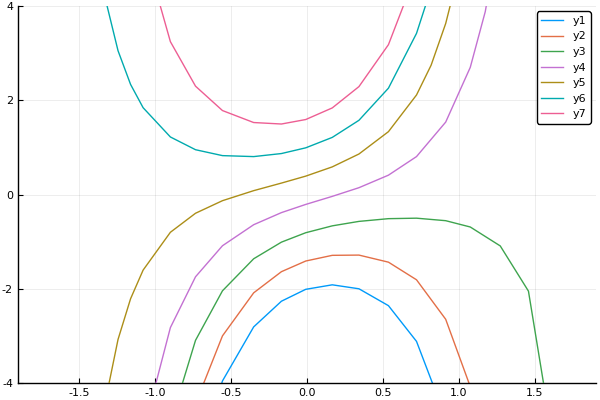

In [1]:
as = -2:0.6:2
ex = out.rhs()
p = plot(ex(a=>as[1]), -1.8, 1.8, ylims=(-4, 4))
[plot!(p, ex(a=>i), -1.8, 1.8, ylims=(-4, 4)) for i in as[2:end]]
p

<p>The comment from the example is "This plots several integral curves of the equation for different values of $a$. The plot shows that the solutions have an inflection point if the parameter  lies between $-1$ and $1$ , while a global maximum or minimum arises for other values of $a$."</p>

<h5>Example</h5>

<p>We continue with another example from the Wolfram documentation, that of solving $y'' + 5y' + 6y=0$ with values prescribed for both $y$ and $y'$ at $x_0=0$.</p>

In [1]:
y = SymFunction("y")
x = symbols("x")
eqn = y''(x) + 5y'(x) + 6y(x)

<p>To solve with $y(0) = 1$ and $y'(0) = 1$ we have:</p>

In [1]:
out = dsolve(eqn, x, (y, 0, 1), (y', 0, 1))

<p>To make a plot, we only need the right-hand-side of the answer:</p>

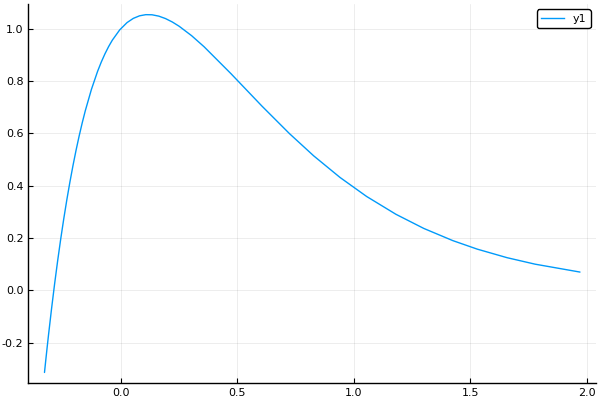

In [1]:
plot(out.rhs(), -1/3, 2)

<h5>Example</h5>

<p>Boundary value problems can be solved for, as well, through a similar syntax. Continuing with examples from the <a href="https://reference.wolfram.com/language/tutorial/DSolveLinearBVPs.html">Wolfram</a> page, we solve $y''(x) +y(x) = e^x$ over $[0,1]$ with conditions $y(0)=1$, $y(1) = 1/2$:</p>

In [1]:
eqn = y''(x) + y(x) - exp(x)
dsolve(eqn, x, (y, 0, 1), (y, 1, 1//2))